# SMS Spam Model Trainning and Testing Notebook

In [1]:
import nltk
import string
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
stopwords.words('english')
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [24]:
# Read Spam Message Data 
SpamData=pd.read_csv('SMSSpamCollection.txt', delimiter = "\t",header=None,names=['Target', 'SMS'])
SpamData

,Target,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


# Data Analysis

In [25]:
# Checking  is there any Duplicates data
SpamData[SpamData.duplicated()==True] 

,Target,SMS
103,ham,As per your request 'Melle Melle (Oru Minnamin...
154,ham,As per your request 'Melle Melle (Oru Minnamin...
207,ham,"As I entered my cabin my PA said, '' Happy B'd..."
223,ham,"Sorry, I'll call later"
326,ham,No calls..messages..missed calls
...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...
5535,ham,"I know you are thinkin malaria. But relax, chi..."
5539,ham,Just sleeping..and surfing
5553,ham,Hahaha..use your brain dear


In [26]:
#Drop Duplicate data
SpamData.drop_duplicates(inplace=True)

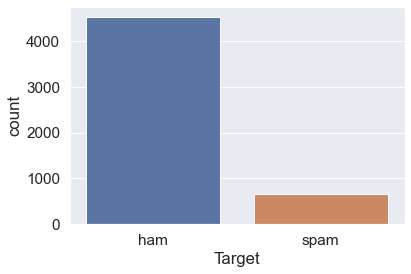

In [5]:
#Plotting Counter of lables in data
sns.set(font_scale=1.4)
ax = sns.countplot(x="Target", data=SpamData,)

In [6]:
#Create New Column of length of the SMS text.
SpamData['Length Of SMS'] = SpamData['SMS'].str.len()

### Average length of "ham" SMS

In [7]:
#Count Average length of the ham SMS
SpamData['Length Of SMS'][SpamData['Target']=='ham'].mean()

70.90589016829053

### Average length of "spam" SMS

In [8]:
#Count Average length of the spam SMS
SpamData['Length Of SMS'][SpamData['Target']=='spam'].mean()

137.70444104134762

# Pre-Processing on Data (Text Data Pre-Processing)

In [9]:
#Encoding Label data ex(ham:0,Spam:1)
encoder = LabelEncoder() #Define Object of LabelEncoder
SpamData['Target'] = encoder.fit_transform(SpamData['Target']) #Applied Lableencoder

### Some Basic Step to Follow for Text Data Preprocesing
    1) Convert Text into Lowercase
    2) Tokennization of the text
    3) Remove special characters
    4) Remove Stop Words
    5) Stemming of words

In [10]:
#Create One Function which process above 5 Steps

ps = PorterStemmer() #Define object for to stremming the data step no 5

def PreProcessedSMS(SMS):
    SMS = SMS.lower() #Convert All words into lowercase ex. Hello THERE => hello there.
    SMS = nltk.wordpunct_tokenize(SMS) #Generate Tokend of Text ex.  hello there => ['hello','there']
    
    # loop for remove special character ex. @account => account
    y = []
    for word in SMS:
        if word.isalnum():
            y.append(word)
            
    SMS = y[:]
    y.clear()
    
    # loop for remove stopwords "There are Spiders" => "Spiders"
    for word in SMS:
        if word not in stopwords.words('english') and word not in string.punctuation:
            y.append(word)
            
            
    SMS = y[:]
    y.clear()
    
    # loop for Stemming the text Ex.  Played => Play
    for word in SMS:
        y.append(ps.stem(word))
    
    return " ".join(y)

In [11]:
#PreProcessedSMS function Apply on SMS Text
SpamData['PreProcessedSMS'] = SpamData['SMS'].apply(PreProcessedSMS)

### Vectorization on PreProcessedSMS Text
#### Why Vectorization?
Vectorization Process convert text into some numeric vector form and compare to normal text numeric vector  process fast and effective to train prediction model.

#### Ways to do Vectorization
    1.Bag of words
    2.tf-Idf
#### Why tf-Idf ?
Bag of Words  created a vector of count the word occurrences  in the sentence and in tf-idf created a vector of importance value of the perticuler word in the sentence and   main reason to choose tf-idf  are perform effectivly better and faster in machine lerning models.
    
    

In [12]:
#Define Object of Tf-idf Vectorizer
tfidf = TfidfVectorizer()

#Apply tf-idf on  Pre-Processed SMS and create vector
X = tfidf.fit_transform(SpamData['PreProcessedSMS']).toarray()

# Create Vector of Labels
y =SpamData['Target'].values

### Save tf-idf Object 

#### Why?

When model is trained and to predict some SMS then we have to also first Convert that sms text into vectorization. 

In [13]:
#using pickle module it save the tf-idf object
pickle.dump(tfidf, open("tfidf.pickle", "wb"))

# Model Trainnig & Testing

In [14]:
# split a dataset into train and test sets ratio of 80 % for training and 20 % for testing
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2)

### Logistic Regression

#### Why Logistic Regression?

Our spamSMScollection dataset have binary Target(Ex. 'Spam' or 'ham').For this type of data Logistic Regression algorithm is used because this algorithm based on the concept of probability.Logistic regression transforms its output using the logistic sigmoid function to return a probability value.



In [19]:
#Create LogisticRegression object
lrc = LogisticRegression(solver='liblinear', penalty='l1')

#Apply Logistic Regression on train datset
lrc.fit(X_train,y_train)

#Testing of model
y_pred = lrc.predict(X_test)

#Calculating Accuracy and Precision
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
    
print(f"Accuracy of model= {round(accuracy*100,2)}%")
print(f"Precision of model= {round(precision*100,2)}%")

Accuracy of model= 95.55%
Precision of model= 94.44%


In [16]:
#Save Trained model for future purpose
pickle.dump(lrc, open("SMSSpamPredictionModel.pickle", "wb"))